In [1]:
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

2025-01-16 00:30:35.282937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 00:30:35.451334: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 00:30:36.424764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-16 00:30:36.424845

In [3]:
# Load original model
original_model_base = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model_base.trainable = False  # Freeze weights
original_model_strong = tf.keras.models.load_model('CNNModel/StrongCNN.keras')  # Replace with your model file
original_model_strong.trainable = False  # Freeze weights
original_model_simple = tf.keras.models.load_model('CNNModel/simpleCNN.keras')  # Replace with your model file


original_model_simple.trainabl=False

original_model = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights



2025-01-16 00:30:40.402430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19160 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-01-16 00:30:40.404723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20682 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


In [4]:
# @ layers with 2 deconvolution layers
def build_atn(input_shape):
    model = tf.keras.Sequential([
        # First convolutional layers to capture features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Downsample (14, 14, 64)

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample (7, 7, 128)

        # Fully connected layer to integrate features
        layers.Flatten(),  # Flatten to shape (7 * 7 * 128 = 6272)
        layers.Dense(6272, activation='relu'),  # Match the reshape target

        # Deconvolution layers to reconstruct adversarial examples
        layers.Reshape((7, 7, 128)),  # Reshape for deconvolution
        layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),  # (14, 14, 128)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),  # (28, 28, 64)
        
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),  # Output layer (28, 28, 1)
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model

# Build the ATN
input_shape = (28, 28, 1)  # MNIST dataset shape
atn = build_atn(input_shape)


In [5]:
# Define ATN 2 Layers only convulution
###
'''
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)
'''

"\ndef build_atn(input_shape):\n    model = tf.keras.Sequential([\n        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]\n        layers.Reshape(input_shape),\n        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]\n    ])\n    return model\n\n\ninput_shape = (28, 28, 1)  # Assuming MNIST dataset\natn = build_atn(input_shape)\n"

In [6]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [7]:
def get_second_highest_target(y_pred_original):
    # Sort predictions to find the highest and second-highest indices
    top_2_indices = tf.argsort(y_pred_original, direction='DESCENDING', axis=1)[:, :2]
    second_highest_indices = top_2_indices[:, 1]

    # Create one-hot encoding for the second-highest class
    y_target = tf.one_hot(second_highest_indices, depth=y_pred_original.shape[1])
    return y_target


In [8]:
class RandomApply(tf.keras.layers.Layer):
    def __init__(self, layer, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.p = p

    def call(self, x, training=None):
        if not training:
            return x
        return tf.cond(
            tf.random.uniform(()) < self.p,
            lambda: self.layer(x, training=training),
            lambda: x
        )

# A simple pipeline: horizontal flip, random rotation
data_augmentation = tf.keras.Sequential([
    RandomApply(layers.RandomRotation(0.2), p=0.5),
    RandomApply(layers.RandomZoom(0.1,fill_mode='nearest'), p=0.5),
])
augmentation_with_p = RandomApply(data_augmentation, p=0)


In [9]:
# Define learning rate schedule
boundaries = [900000]  # Steps at which learning rate changes
values = [0.001, 0.0001]  # Corresponding learning rates

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
beta = 0.01  # Weight for input-space loss
models = [original_model_base, original_model_strong, original_model_simple]

@tf.function

def train_step(x, y_original, selected_model):
    with tf.GradientTape() as tape:
        # Generate adversarial examples
        x_prime = atn(x)

        # Get predictions for original and adversarial inputs using the selected model
        y_pred_original = selected_model(x, training=False)
        y_pred = selected_model(x_prime, training=False)

        # Compute the second-highest target dynamically
        y_target = get_second_highest_target(y_pred_original)

        # Compute input loss and output loss separately
        l_x = input_loss(x, x_prime)
        l_y = output_loss(y_pred , y_target )

        # Compute the combined loss
        loss = beta * l_x + l_y

    # Compute and apply gradients
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))

    # Return total loss, input loss, and output loss
    return loss, l_x, l_y

In [10]:
# Load MNIST datasetatn
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
#def create_adversarial_target(label):
#    # Example: Shift each label by 1 (cyclic mapping)
#    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Do NOT normalize the images; keep them in the range [0, 255]
    image = tf.cast(image, tf.float32)  # Ensure float32 for compatibility with loss functions
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Return only the raw image and the original label
    return image, label_one_hot

# Apply preprocessing to the dataset
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch and prefetch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded without normalization.")


Dataset loaded without normalization.


In [11]:
from tqdm import tqdm
import time
import numpy as np

# Training parameters
epochs = 1000
epoch_losses = []
epoch_input_losses = []
epoch_output_losses = []
epoch_models = []  # To store the name of the selected model

# Loss history for each model
loss_history = {
    "BaseCNN": [],
    "StrongCNN": [],
    "SimpleCNN": []
}

# Model mapping
model_names = {
    original_model_base: "BaseCNN",
    original_model_strong: "StrongCNN",
    original_model_simple: "SimpleCNN"
}

print(f"{'Epoch':<8}{'Model':<12}{'Total Loss':<12}{'Input Loss':<12}{'Output Loss':<12}{'Time (s)':<10}")
print("-" * 60)

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    epoch_input_loss = 0
    epoch_output_loss = 0
    batch_count = 0

    # Select the model based on the global 5-epoch average
    selected_model = None
    selected_model_name = None
    shuffled_models = list(model_names.items())
    random.shuffle(shuffled_models)

    # Select the model
    selected_model = None
    selected_model_name = None

    for model, name in shuffled_models:
        if len(loss_history[name]) < 5:  # If less than 5 epochs, prioritize this model
            selected_model = model
            selected_model_name = name
            break

        avg_last_5 = np.mean(loss_history[name][-3:])  # Average of the last 3 epochs for the current model

        # Calculate the global average of the most recent 5 epochs across all models
        global_avg_last_5 = np.mean(epoch_losses[-5:])

        # Select the model if its recent average loss is greater than the global average
        if selected_model is None or avg_last_5 > global_avg_last_5:
            selected_model = model
            selected_model_name = name

    # Training loop for the selected model
    for x_batch, y_original_batch in tqdm(mnist_train_atn, desc=f"Epoch {epoch + 1}/{epochs} - {selected_model_name}"):
        loss, l_x, l_y = train_step(x_batch, y_original_batch, selected_model)
        epoch_loss += loss.numpy()
        epoch_input_loss += l_x.numpy() * beta
        epoch_output_loss += l_y.numpy()
        batch_count += 1

    # Compute average losses for the epoch
    avg_loss = epoch_loss / batch_count
    avg_input_loss = epoch_input_loss / batch_count
    avg_output_loss = epoch_output_loss / batch_count
    elapsed_time = time.time() - start_time

    # Append losses to the lists
    epoch_losses.append(avg_loss)
    epoch_input_losses.append(avg_input_loss)
    epoch_output_losses.append(avg_output_loss)
    epoch_models.append(selected_model_name)

    # Update loss history for the selected model
    loss_history[selected_model_name].append(avg_loss)

    # Print epoch summary
    print(f"{epoch + 1:<8}{selected_model_name:<12}{avg_loss:<12.4f}{avg_input_loss:<12.4f}{avg_output_loss:<12.4f}{elapsed_time:<10.2f}")


Epoch   Model       Total Loss  Input Loss  Output Loss Time (s)  
------------------------------------------------------------


Epoch 1/1000 - SimpleCNN:   0%|          | 0/1875 [00:00<?, ?it/s]2025-01-16 00:30:45.258060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2025-01-16 00:30:46.724008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Epoch 1/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:33<00:00, 55.83it/s]


1       SimpleCNN   8.8143      6.8713      1.9430      33.59     


Epoch 2/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:28<00:00, 64.68it/s]


2       BaseCNN     5.9975      4.2123      1.7852      29.00     


Epoch 3/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.87it/s]


3       SimpleCNN   4.7290      3.2285      1.5006      26.10     


Epoch 4/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.31it/s]


4       BaseCNN     4.8857      3.3867      1.4989      26.68     


Epoch 5/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:34<00:00, 54.92it/s]


5       StrongCNN   8.1714      5.6061      2.5653      34.14     


Epoch 6/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.65it/s]


6       StrongCNN   6.5668      4.7906      1.7762      33.10     


Epoch 7/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.42it/s]


7       BaseCNN     4.7991      3.3087      1.4904      26.63     


Epoch 8/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.74it/s]


8       BaseCNN     4.0381      2.9015      1.1366      26.14     


Epoch 9/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.39it/s]


9       StrongCNN   7.0054      4.8661      2.1393      32.12     


Epoch 10/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.07it/s]


10      StrongCNN   5.8601      4.3679      1.4922      32.86     


Epoch 11/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.68it/s]


11      StrongCNN   5.5291      4.2365      1.2926      32.52     


Epoch 12/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.43it/s]


12      BaseCNN     4.3733      3.0743      1.2990      26.63     


Epoch 13/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.47it/s]


13      SimpleCNN   4.2429      2.7036      1.5394      25.53     


Epoch 14/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.26it/s]


14      SimpleCNN   3.5470      2.4299      1.1171      26.32     


Epoch 15/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.15it/s]


15      SimpleCNN   3.2083      2.3178      0.8905      26.36     


Epoch 16/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.30it/s]


16      StrongCNN   6.7731      4.7045      2.0685      32.17     


Epoch 17/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.06it/s]


17      StrongCNN   5.4346      4.1265      1.3082      32.30     


Epoch 18/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.72it/s]


18      StrongCNN   5.1350      4.0008      1.1342      31.94     


Epoch 19/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.07it/s]


19      StrongCNN   4.9188      3.9069      1.0119      31.22     


Epoch 20/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]


20      StrongCNN   4.7873      3.8482      0.9391      32.20     


Epoch 21/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


21      StrongCNN   4.6710      3.7992      0.8718      32.34     


Epoch 22/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.03it/s]


22      BaseCNN     4.6288      3.1104      1.5185      26.78     


Epoch 23/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.56it/s]


23      BaseCNN     3.7831      2.6944      1.0888      26.58     


Epoch 24/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.18it/s]


24      StrongCNN   5.6516      4.2047      1.4469      32.23     


Epoch 25/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.55it/s]


25      StrongCNN   4.6908      3.7942      0.8966      32.03     


Epoch 26/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


26      StrongCNN   4.5333      3.7238      0.8094      32.33     


Epoch 27/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.28it/s]


27      StrongCNN   4.4140      3.6668      0.7472      32.74     


Epoch 28/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.74it/s]


28      SimpleCNN   4.0413      2.6367      1.4046      25.44     


Epoch 29/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.15it/s]


29      StrongCNN   5.0552      3.9235      1.1318      31.18     


Epoch 30/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


30      StrongCNN   4.3677      3.6283      0.7395      32.08     


Epoch 31/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


31      StrongCNN   4.2577      3.5694      0.6882      32.07     


Epoch 32/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.10it/s]


32      StrongCNN   4.2147      3.5542      0.6605      31.73     


Epoch 33/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.05it/s]


33      SimpleCNN   3.7491      2.5260      1.2231      26.40     


Epoch 34/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.13it/s]


34      BaseCNN     4.3656      2.9134      1.4522      26.37     


Epoch 35/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.25it/s]


35      StrongCNN   5.1765      3.9755      1.2010      32.19     


Epoch 36/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


36      StrongCNN   4.2906      3.5864      0.7042      32.11     


Epoch 37/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.17it/s]


37      StrongCNN   4.1567      3.5129      0.6438      32.24     


Epoch 38/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.73it/s]


38      StrongCNN   4.1221      3.4935      0.6286      31.94     


Epoch 39/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.23it/s]


39      SimpleCNN   3.6226      2.4762      1.1464      25.61     


Epoch 40/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.26it/s]


40      BaseCNN     4.1557      2.8234      1.3322      25.96     


Epoch 41/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.19it/s]


41      StrongCNN   5.0254      3.9259      1.0995      31.16     


Epoch 42/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.21it/s]


42      StrongCNN   4.1848      3.5296      0.6552      32.22     


Epoch 43/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.78it/s]


43      StrongCNN   4.1118      3.4926      0.6193      32.46     


Epoch 44/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.73it/s]


44      StrongCNN   4.0480      3.4600      0.5881      32.49     


Epoch 45/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.30it/s]


45      StrongCNN   3.9661      3.4140      0.5521      32.17     


Epoch 46/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.20it/s]


46      StrongCNN   3.9754      3.4187      0.5567      32.23     


Epoch 47/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.40it/s]


47      BaseCNN     4.2404      2.9136      1.3268      26.64     


Epoch 48/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.15it/s]


48      BaseCNN     3.5148      2.5567      0.9581      26.36     


Epoch 49/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.07it/s]


49      BaseCNN     3.2662      2.4619      0.8043      26.39     


Epoch 50/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.71it/s]


50      StrongCNN   5.0853      3.9419      1.1434      31.41     


Epoch 51/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.51it/s]


51      StrongCNN   4.1435      3.5112      0.6323      32.05     


Epoch 52/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.29it/s]


52      StrongCNN   3.9984      3.4303      0.5682      32.17     


Epoch 53/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.50it/s]


53      StrongCNN   3.9866      3.4250      0.5616      32.06     


Epoch 54/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.74it/s]


54      BaseCNN     3.7561      2.7278      1.0283      26.51     


Epoch 55/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.46it/s]


55      BaseCNN     3.1754      2.4377      0.7377      26.62     


Epoch 56/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.59it/s]


56      StrongCNN   4.8132      3.8157      0.9975      31.47     


Epoch 57/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.82it/s]


57      StrongCNN   4.0560      3.4640      0.5920      31.35     


Epoch 58/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.62it/s]


58      StrongCNN   4.0379      3.4586      0.5793      32.00     


Epoch 59/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


59      StrongCNN   4.0207      3.4485      0.5722      32.11     


Epoch 60/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.35it/s]


60      StrongCNN   3.9639      3.4159      0.5480      31.08     


Epoch 61/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.28it/s]


61      BaseCNN     3.6866      2.7117      0.9748      26.31     


Epoch 62/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.46it/s]


62      StrongCNN   4.4387      3.6293      0.8093      32.08     


Epoch 63/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]


63      StrongCNN   3.9600      3.4150      0.5450      32.20     


Epoch 64/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.78it/s]


64      StrongCNN   3.9514      3.4159      0.5355      32.46     


Epoch 65/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.27it/s]


65      StrongCNN   4.0088      3.4614      0.5474      32.19     


Epoch 66/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.32it/s]


66      SimpleCNN   4.0000      2.5876      1.4124      26.30     


Epoch 67/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.66it/s]


67      StrongCNN   4.5155      3.6650      0.8505      31.97     


Epoch 68/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.50it/s]


68      StrongCNN   3.9470      3.4091      0.5379      32.61     


Epoch 69/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.02it/s]


69      StrongCNN   3.9210      3.3914      0.5296      31.78     


Epoch 70/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.93it/s]


70      StrongCNN   3.9401      3.4181      0.5220      31.30     


Epoch 71/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.17it/s]


71      StrongCNN   3.9814      3.4482      0.5332      32.24     


Epoch 72/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.91it/s]


72      SimpleCNN   3.7507      2.5138      1.2369      26.45     


Epoch 73/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.73it/s]


73      StrongCNN   4.4244      3.6126      0.8118      31.93     


Epoch 74/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.22it/s]


74      StrongCNN   3.9592      3.4220      0.5372      32.21     


Epoch 75/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.31it/s]


75      StrongCNN   3.9571      3.4249      0.5322      32.16     


Epoch 76/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.51it/s]


76      StrongCNN   3.9912      3.4524      0.5388      31.51     


Epoch 77/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.41it/s]


77      BaseCNN     4.2501      2.9532      1.2969      27.02     


Epoch 78/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.94it/s]


78      SimpleCNN   3.5986      2.4124      1.1862      26.44     


Epoch 79/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


79      StrongCNN   4.6549      3.7369      0.9179      32.07     


Epoch 80/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.07it/s]


80      StrongCNN   3.9472      3.4089      0.5383      32.30     


Epoch 81/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.02it/s]


81      StrongCNN   3.9378      3.4144      0.5234      31.25     


Epoch 82/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.29it/s]


82      StrongCNN   3.9632      3.4353      0.5280      32.18     


Epoch 83/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.57it/s]


83      SimpleCNN   3.4939      2.4233      1.0706      26.21     


Epoch 84/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.81it/s]


84      BaseCNN     3.9867      2.7773      1.2093      26.87     


Epoch 85/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.66it/s]


85      StrongCNN   4.6445      3.7383      0.9062      32.53     


Epoch 86/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.07it/s]


86      StrongCNN   3.9606      3.4112      0.5494      32.29     


Epoch 87/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.94it/s]


87      StrongCNN   3.9282      3.4069      0.5213      32.37     


Epoch 88/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.99it/s]


88      StrongCNN   3.9730      3.4392      0.5338      31.79     


Epoch 89/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.32it/s]


89      StrongCNN   4.0102      3.4614      0.5488      31.61     


Epoch 90/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.04it/s]


90      BaseCNN     3.9651      2.8335      1.1315      26.04     


Epoch 91/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.65it/s]


91      StrongCNN   4.4523      3.6571      0.7952      31.44     


Epoch 92/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


92      StrongCNN   3.9711      3.4241      0.5470      32.38     


Epoch 93/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.38it/s]


93      StrongCNN   3.9357      3.4064      0.5294      32.13     


Epoch 94/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.20it/s]


94      StrongCNN   3.9865      3.4498      0.5367      32.22     


Epoch 95/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.33it/s]


95      BaseCNN     3.8634      2.8021      1.0613      26.67     


Epoch 96/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


96      StrongCNN   4.4531      3.6501      0.8030      32.11     


Epoch 97/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.36it/s]


97      StrongCNN   3.9971      3.4662      0.5308      32.13     


Epoch 98/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


98      StrongCNN   3.9799      3.4545      0.5254      32.25     


Epoch 99/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.49it/s]


99      StrongCNN   4.0100      3.4619      0.5481      32.07     


Epoch 100/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.78it/s]


100     StrongCNN   3.9952      3.4781      0.5171      30.85     


Epoch 101/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.09it/s]


101     StrongCNN   4.0283      3.4782      0.5501      31.74     


Epoch 102/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.51it/s]


102     StrongCNN   4.0161      3.4865      0.5296      32.61     


Epoch 103/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]


103     StrongCNN   4.0174      3.4818      0.5356      32.33     


Epoch 104/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.99it/s]


104     StrongCNN   4.0591      3.4947      0.5644      32.34     


Epoch 105/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.09it/s]


105     StrongCNN   3.9830      3.4536      0.5294      32.28     


Epoch 106/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.77it/s]


106     BaseCNN     4.0526      2.9034      1.1493      26.50     


Epoch 107/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.01it/s]


107     StrongCNN   4.4630      3.6567      0.8063      31.78     


Epoch 108/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.08it/s]


108     StrongCNN   3.9078      3.3990      0.5088      31.75     


Epoch 109/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.64it/s]


109     StrongCNN   3.9194      3.4077      0.5117      32.54     


Epoch 110/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.82it/s]


110     StrongCNN   3.9126      3.4099      0.5027      31.35     


Epoch 111/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.83it/s]


111     BaseCNN     3.8756      2.8256      1.0500      25.75     


Epoch 112/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.08it/s]


112     BaseCNN     3.3338      2.5328      0.8009      26.02     


Epoch 113/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.52it/s]


113     StrongCNN   4.5606      3.7291      0.8315      32.05     


Epoch 114/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.04it/s]


114     StrongCNN   3.9624      3.4321      0.5303      32.31     


Epoch 115/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.84it/s]


115     StrongCNN   3.9766      3.4354      0.5412      32.43     


Epoch 116/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.11it/s]


116     StrongCNN   3.9638      3.4382      0.5256      32.27     


Epoch 117/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.77it/s]


117     StrongCNN   3.9276      3.4157      0.5119      31.91     


Epoch 118/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.67it/s]


118     BaseCNN     3.6294      2.7228      0.9066      26.54     


Epoch 119/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]


119     StrongCNN   4.3938      3.6262      0.7676      32.20     


Epoch 120/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.20it/s]


120     StrongCNN   3.9415      3.4147      0.5268      31.68     


Epoch 121/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.61it/s]


121     StrongCNN   3.9473      3.4291      0.5183      31.46     


Epoch 122/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.97it/s]


122     StrongCNN   4.0297      3.4833      0.5464      31.80     


Epoch 123/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.27it/s]


123     StrongCNN   3.9982      3.4689      0.5293      32.19     


Epoch 124/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.98it/s]


124     SimpleCNN   4.1056      2.6504      1.4552      26.42     


Epoch 125/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.61it/s]


125     SimpleCNN   3.3415      2.3344      1.0072      26.19     


Epoch 126/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.91it/s]


126     StrongCNN   4.7761      3.8027      0.9734      32.39     


Epoch 127/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.41it/s]


127     StrongCNN   3.9517      3.4244      0.5274      32.11     


Epoch 128/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.98it/s]


128     StrongCNN   3.9188      3.4057      0.5131      32.35     


Epoch 129/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.41it/s]


129     StrongCNN   3.9457      3.4299      0.5158      32.11     


Epoch 130/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.74it/s]


130     BaseCNN     3.8278      2.8022      1.0256      27.29     


Epoch 131/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.91it/s]


131     StrongCNN   4.3051      3.5781      0.7271      31.84     


Epoch 132/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.65it/s]


132     StrongCNN   3.8914      3.3685      0.5229      32.53     


Epoch 133/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.76it/s]


133     StrongCNN   3.8788      3.3781      0.5008      31.92     


Epoch 134/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.00it/s]


134     StrongCNN   3.9450      3.4212      0.5238      31.78     


Epoch 135/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.31it/s]


135     BaseCNN     3.6884      2.7469      0.9414      26.68     


Epoch 136/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.07it/s]


136     StrongCNN   4.3231      3.5878      0.7352      31.75     


Epoch 137/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.72it/s]


137     StrongCNN   3.9368      3.4125      0.5243      31.94     


Epoch 138/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.58it/s]


138     StrongCNN   3.9088      3.3923      0.5165      31.48     


Epoch 139/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


139     StrongCNN   3.9594      3.4408      0.5186      32.07     


Epoch 140/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.70it/s]


140     StrongCNN   3.9859      3.4574      0.5284      31.95     


Epoch 141/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.29it/s]


141     StrongCNN   3.8823      3.3831      0.4993      31.63     


Epoch 142/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.21it/s]


142     StrongCNN   3.9552      3.4403      0.5149      32.22     


Epoch 143/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.65it/s]


143     StrongCNN   3.9213      3.4039      0.5174      32.53     


Epoch 144/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.89it/s]


144     SimpleCNN   3.9548      2.6150      1.3398      26.09     


Epoch 145/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.99it/s]


145     StrongCNN   4.3758      3.5947      0.7811      31.79     


Epoch 146/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.56it/s]


146     StrongCNN   3.8033      3.3233      0.4800      32.03     


Epoch 147/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.98it/s]


147     StrongCNN   3.8933      3.3893      0.5041      32.35     


Epoch 148/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.18it/s]


148     StrongCNN   3.8589      3.3605      0.4984      32.24     


Epoch 149/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.67it/s]


149     SimpleCNN   3.6470      2.5090      1.1379      26.17     


Epoch 150/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.46it/s]


150     BaseCNN     3.9537      2.8174      1.1363      27.00     


Epoch 151/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.12it/s]


151     StrongCNN   4.4088      3.6116      0.7972      31.72     


Epoch 152/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.47it/s]


152     StrongCNN   3.8618      3.3615      0.5002      31.54     


Epoch 153/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.52it/s]


153     StrongCNN   3.8154      3.3250      0.4904      32.05     


Epoch 154/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.55it/s]


154     StrongCNN   3.8218      3.3311      0.4907      32.59     


Epoch 155/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.06it/s]


155     BaseCNN     3.7379      2.7559      0.9819      26.77     


Epoch 156/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.26it/s]


156     StrongCNN   4.2238      3.5242      0.6996      32.19     


Epoch 157/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.29it/s]


157     StrongCNN   3.8630      3.3660      0.4969      31.63     


Epoch 158/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.31it/s]


158     StrongCNN   3.8275      3.3443      0.4831      32.16     


Epoch 159/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


159     StrongCNN   3.8312      3.3312      0.4999      32.31     


Epoch 160/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.43it/s]


160     SimpleCNN   3.6949      2.5176      1.1773      25.90     


Epoch 161/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.97it/s]


161     BaseCNN     3.6245      2.6723      0.9522      26.43     


Epoch 162/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.58it/s]


162     StrongCNN   4.3753      3.5855      0.7898      31.48     


Epoch 163/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.37it/s]


163     StrongCNN   3.8332      3.3425      0.4907      32.13     


Epoch 164/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.98it/s]


164     StrongCNN   3.8124      3.3210      0.4914      31.80     


Epoch 165/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.07it/s]


165     StrongCNN   3.8648      3.3703      0.4945      32.30     


Epoch 166/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.35it/s]


166     BaseCNN     3.5920      2.7038      0.8881      26.66     


Epoch 167/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


167     StrongCNN   4.1951      3.4886      0.7064      32.31     


Epoch 168/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.86it/s]


168     StrongCNN   3.8794      3.3590      0.5205      32.42     


Epoch 169/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.90it/s]


169     StrongCNN   3.8643      3.3512      0.5131      31.84     


Epoch 170/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.97it/s]


170     StrongCNN   3.8138      3.3199      0.4939      32.35     


Epoch 171/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.57it/s]


171     SimpleCNN   3.6347      2.5049      1.1298      26.20     


Epoch 172/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.57it/s]


172     SimpleCNN   3.0944      2.2651      0.8293      25.85     


Epoch 173/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.23it/s]


173     StrongCNN   4.5026      3.6519      0.8507      31.66     


Epoch 174/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.08it/s]


174     StrongCNN   3.9076      3.3675      0.5401      31.75     


Epoch 175/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


175     StrongCNN   3.8462      3.3400      0.5062      32.24     


Epoch 176/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.04it/s]


176     StrongCNN   3.8754      3.3724      0.5030      32.32     


Epoch 177/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.58it/s]


177     StrongCNN   3.8782      3.3583      0.5198      31.48     


Epoch 178/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.23it/s]


178     StrongCNN   3.8569      3.3618      0.4951      32.21     


Epoch 179/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.64it/s]


179     BaseCNN     3.8185      2.8145      1.0040      26.55     


Epoch 180/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.25it/s]


180     StrongCNN   4.1711      3.4864      0.6847      32.20     


Epoch 181/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.46it/s]


181     StrongCNN   3.8698      3.3687      0.5011      32.08     


Epoch 182/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.43it/s]


182     StrongCNN   3.9833      3.4273      0.5560      31.56     


Epoch 183/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


183     StrongCNN   3.9598      3.4220      0.5378      32.16     


Epoch 184/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.33it/s]


184     BaseCNN     3.7122      2.7770      0.9352      26.67     


Epoch 185/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.79it/s]


185     BaseCNN     3.2946      2.5453      0.7494      26.50     


Epoch 186/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.76it/s]


186     StrongCNN   4.4963      3.6542      0.8421      31.92     


Epoch 187/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.37it/s]


187     StrongCNN   3.7992      3.3129      0.4863      32.13     


Epoch 188/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.36it/s]


188     StrongCNN   3.8687      3.3626      0.5060      32.13     


Epoch 189/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.84it/s]


189     StrongCNN   3.7891      3.2990      0.4900      31.87     


Epoch 190/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.08it/s]


190     BaseCNN     3.4906      2.6793      0.8112      26.76     


Epoch 191/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.17it/s]


191     BaseCNN     3.1408      2.4854      0.6554      26.73     


Epoch 192/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.06it/s]


192     StrongCNN   4.3165      3.5719      0.7446      32.30     


Epoch 193/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.46it/s]


193     StrongCNN   3.8889      3.3730      0.5158      31.54     


Epoch 194/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]


194     StrongCNN   3.8758      3.3539      0.5220      32.20     


Epoch 195/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.54it/s]


195     StrongCNN   3.9240      3.4020      0.5220      32.03     


Epoch 196/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.49it/s]


196     StrongCNN   3.9698      3.4160      0.5538      32.06     


Epoch 197/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.25it/s]


197     StrongCNN   3.9490      3.4170      0.5319      32.20     


Epoch 198/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.39it/s]


198     StrongCNN   3.8790      3.3615      0.5175      32.12     


Epoch 199/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.91it/s]


199     StrongCNN   3.9278      3.4077      0.5201      32.38     


Epoch 200/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.89it/s]


200     SimpleCNN   3.8914      2.6323      1.2591      26.09     


Epoch 201/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.61it/s]


201     BaseCNN     3.5318      2.6724      0.8594      26.56     


Epoch 202/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.31it/s]


202     StrongCNN   4.4609      3.6189      0.8420      31.62     


Epoch 203/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.88it/s]


203     StrongCNN   3.8081      3.3127      0.4954      31.32     


Epoch 204/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.20it/s]


204     StrongCNN   3.8947      3.3506      0.5441      32.22     


Epoch 205/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.31it/s]


205     StrongCNN   3.9140      3.3961      0.5179      32.16     


Epoch 206/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.39it/s]


206     BaseCNN     3.5137      2.7006      0.8131      26.64     


Epoch 207/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.26it/s]


207     SimpleCNN   3.5888      2.4515      1.1373      26.32     


Epoch 208/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.59it/s]


208     StrongCNN   4.3816      3.5711      0.8105      32.56     


Epoch 209/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


209     StrongCNN   3.8318      3.3111      0.5207      32.38     


Epoch 210/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


210     StrongCNN   3.8679      3.3454      0.5224      32.11     


Epoch 211/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.99it/s]


211     StrongCNN   3.8428      3.3274      0.5154      31.79     


Epoch 212/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.43it/s]


212     BaseCNN     3.4548      2.6760      0.7788      26.63     


Epoch 213/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.30it/s]


213     BaseCNN     3.1095      2.4840      0.6255      26.68     


Epoch 214/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.36it/s]


214     StrongCNN   4.5122      3.6629      0.8493      31.07     


Epoch 215/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.38it/s]


215     StrongCNN   3.9942      3.4369      0.5573      32.12     


Epoch 216/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


216     StrongCNN   3.9555      3.4252      0.5303      32.07     


Epoch 217/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.15it/s]


217     StrongCNN   3.9892      3.4133      0.5759      32.25     


Epoch 218/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.14it/s]


218     StrongCNN   3.9176      3.3877      0.5299      32.26     


Epoch 219/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.80it/s]


219     BaseCNN     3.4004      2.6690      0.7313      26.87     


Epoch 220/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


220     StrongCNN   4.2184      3.5024      0.7160      32.23     


Epoch 221/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.98it/s]


221     StrongCNN   3.9633      3.3937      0.5697      32.34     


Epoch 222/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.21it/s]


222     StrongCNN   4.0068      3.4207      0.5861      32.22     


Epoch 223/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.52it/s]


223     StrongCNN   3.9199      3.3697      0.5502      32.05     


Epoch 224/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.01it/s]


224     StrongCNN   3.9129      3.3654      0.5475      31.25     


Epoch 225/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.87it/s]


225     SimpleCNN   3.8651      2.6231      1.2420      26.46     


Epoch 226/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.95it/s]


226     StrongCNN   4.3896      3.5632      0.8264      32.36     


Epoch 227/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.20it/s]


227     StrongCNN   3.8475      3.3327      0.5148      32.22     


Epoch 228/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.93it/s]


228     StrongCNN   3.8085      3.3055      0.5029      32.37     


Epoch 229/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.04it/s]


229     StrongCNN   3.9433      3.3911      0.5522      32.31     


Epoch 230/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


230     StrongCNN   3.9133      3.3791      0.5342      32.38     


Epoch 231/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.51it/s]


231     BaseCNN     3.6180      2.7683      0.8497      26.60     


Epoch 232/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.94it/s]


232     StrongCNN   4.1995      3.4718      0.7278      32.37     


Epoch 233/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s]


233     StrongCNN   3.8242      3.3073      0.5169      32.36     


Epoch 234/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.05it/s]


234     StrongCNN   3.8374      3.3080      0.5293      30.72     


Epoch 235/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]


235     StrongCNN   3.7931      3.2809      0.5123      32.33     


Epoch 236/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


236     StrongCNN   3.8209      3.2889      0.5320      32.07     


Epoch 237/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.04it/s]


237     SimpleCNN   3.7672      2.5822      1.1850      26.40     


Epoch 238/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.75it/s]


238     StrongCNN   4.2040      3.4571      0.7468      31.92     


Epoch 239/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.97it/s]


239     StrongCNN   3.7695      3.2610      0.5085      32.35     


Epoch 240/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.65it/s]


240     StrongCNN   3.8224      3.2922      0.5302      32.53     


Epoch 241/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.69it/s]


241     StrongCNN   3.7416      3.2595      0.4822      32.51     


Epoch 242/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.37it/s]


242     SimpleCNN   3.5146      2.4898      1.0248      26.28     


Epoch 243/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.01it/s]


243     BaseCNN     3.5979      2.7094      0.8886      26.41     


Epoch 244/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.41it/s]


244     SimpleCNN   3.2202      2.3395      0.8807      26.26     


Epoch 245/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.91it/s]


245     StrongCNN   4.3268      3.5309      0.7959      31.30     


Epoch 246/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


246     StrongCNN   3.7714      3.2529      0.5185      32.08     


Epoch 247/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.39it/s]


247     StrongCNN   3.7281      3.2351      0.4929      32.12     


Epoch 248/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.46it/s]


248     StrongCNN   3.7395      3.2427      0.4968      32.08     


Epoch 249/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.92it/s]


249     StrongCNN   3.8111      3.2850      0.5261      31.83     


Epoch 250/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.00it/s]


250     BaseCNN     3.5849      2.7405      0.8444      26.42     


Epoch 251/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.82it/s]


251     StrongCNN   4.1066      3.3951      0.7114      32.43     


Epoch 252/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.63it/s]


252     StrongCNN   3.7109      3.2272      0.4837      32.54     


Epoch 253/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.09it/s]


253     StrongCNN   3.7991      3.2500      0.5491      32.29     


Epoch 254/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.08it/s]


254     StrongCNN   3.7711      3.2721      0.4990      32.29     


Epoch 255/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.78it/s]


255     BaseCNN     3.5383      2.7266      0.8117      25.77     


Epoch 256/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.59it/s]


256     StrongCNN   4.1284      3.4109      0.7176      31.47     


Epoch 257/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.48it/s]


257     StrongCNN   3.7554      3.2495      0.5059      31.53     


Epoch 258/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s]


258     StrongCNN   3.7663      3.2513      0.5150      32.36     


Epoch 259/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


259     StrongCNN   3.8234      3.2938      0.5296      32.09     


Epoch 260/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.47it/s]


260     BaseCNN     3.4775      2.7078      0.7697      26.61     


Epoch 261/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.68it/s]


261     BaseCNN     3.0706      2.4787      0.5918      26.92     


Epoch 262/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.12it/s]


262     StrongCNN   4.2304      3.4634      0.7670      31.72     


Epoch 263/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.22it/s]


263     StrongCNN   3.7976      3.2775      0.5201      32.21     


Epoch 264/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.18it/s]


264     StrongCNN   3.8344      3.2693      0.5651      32.24     


Epoch 265/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.34it/s]


265     StrongCNN   3.7629      3.2517      0.5112      32.15     


Epoch 266/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


266     StrongCNN   3.7692      3.2489      0.5203      32.09     


Epoch 267/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s]


267     SimpleCNN   3.6415      2.5355      1.1060      26.36     


Epoch 268/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]


268     StrongCNN   4.2146      3.4525      0.7621      32.33     


Epoch 269/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


269     StrongCNN   3.7439      3.2379      0.5060      32.38     


Epoch 270/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.51it/s]


270     StrongCNN   3.7201      3.2120      0.5081      32.05     


Epoch 271/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


271     StrongCNN   3.7439      3.2492      0.4947      32.33     


Epoch 272/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s]


272     SimpleCNN   3.4499      2.4685      0.9814      26.35     


Epoch 273/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.00it/s]


273     BaseCNN     3.4531      2.6572      0.7959      26.42     


Epoch 274/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.77it/s]


274     StrongCNN   4.2560      3.4647      0.7912      31.91     


Epoch 275/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.70it/s]


275     StrongCNN   3.7090      3.2178      0.4912      31.95     


Epoch 276/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.29it/s]


276     StrongCNN   3.6591      3.1852      0.4739      31.63     


Epoch 277/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.11it/s]


277     StrongCNN   3.7026      3.1953      0.5073      32.27     


Epoch 278/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.34it/s]


278     SimpleCNN   3.3683      2.4435      0.9248      26.29     


Epoch 279/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


279     StrongCNN   3.9844      3.3311      0.6533      32.23     


Epoch 280/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.91it/s]


280     StrongCNN   3.7672      3.2400      0.5272      32.38     


Epoch 281/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


281     StrongCNN   3.8301      3.2722      0.5579      32.34     


Epoch 282/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.23it/s]


282     StrongCNN   3.7562      3.2585      0.4977      32.21     


Epoch 283/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.66it/s]


283     StrongCNN   3.8724      3.2961      0.5763      31.97     


Epoch 284/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.79it/s]


284     StrongCNN   3.7630      3.2407      0.5224      32.45     


Epoch 285/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.26it/s]


285     BaseCNN     3.6337      2.7757      0.8581      26.69     


Epoch 286/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.20it/s]


286     StrongCNN   4.0813      3.3931      0.6882      31.15     


Epoch 287/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.04it/s]


287     StrongCNN   3.6666      3.1841      0.4825      32.31     


Epoch 288/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.86it/s]


288     StrongCNN   3.8563      3.2868      0.5695      31.87     


Epoch 289/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.64it/s]


289     StrongCNN   3.7582      3.2447      0.5135      32.54     


Epoch 290/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


290     StrongCNN   3.8133      3.2653      0.5480      32.23     


Epoch 291/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.14it/s]


291     SimpleCNN   3.5401      2.5388      1.0013      26.37     


Epoch 292/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.39it/s]


292     StrongCNN   4.1608      3.4085      0.7524      32.12     


Epoch 293/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.37it/s]


293     StrongCNN   3.7531      3.2465      0.5067      32.13     


Epoch 294/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.85it/s]


294     StrongCNN   3.7921      3.2879      0.5042      32.42     


Epoch 295/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.64it/s]


295     StrongCNN   3.7669      3.2450      0.5219      31.98     


Epoch 296/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.89it/s]


296     StrongCNN   3.8292      3.2917      0.5375      31.32     


Epoch 297/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.82it/s]


297     SimpleCNN   3.4110      2.4937      0.9173      26.11     


Epoch 298/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.50it/s]


298     StrongCNN   4.0744      3.3883      0.6861      31.52     


Epoch 299/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.38it/s]


299     StrongCNN   3.8081      3.2732      0.5349      31.59     


Epoch 300/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.35it/s]


300     StrongCNN   3.8380      3.2894      0.5485      31.60     


Epoch 301/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


301     StrongCNN   3.7311      3.2240      0.5071      32.25     


Epoch 302/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


302     StrongCNN   3.9739      3.3460      0.6279      32.23     


Epoch 303/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.52it/s]


303     SimpleCNN   3.3818      2.5006      0.8812      26.60     


Epoch 304/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.63it/s]


304     StrongCNN   4.1404      3.4225      0.7178      31.99     


Epoch 305/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


305     StrongCNN   3.7931      3.2741      0.5190      32.11     


Epoch 306/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.76it/s]


306     StrongCNN   3.9175      3.3512      0.5663      31.38     


Epoch 307/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.26it/s]


307     StrongCNN   3.9584      3.3529      0.6055      31.65     


Epoch 308/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.77it/s]


308     StrongCNN   3.8649      3.3227      0.5423      31.91     


Epoch 309/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.97it/s]


309     StrongCNN   3.8552      3.3062      0.5490      31.80     


Epoch 310/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.57it/s]


310     StrongCNN   3.9456      3.3675      0.5781      32.02     


Epoch 311/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.07it/s]


311     BaseCNN     4.1989      3.0441      1.1548      26.77     


Epoch 312/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.71it/s]


312     StrongCNN   4.2982      3.5101      0.7881      31.94     


Epoch 313/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


313     StrongCNN   3.8111      3.2768      0.5343      32.09     


Epoch 314/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.86it/s]


314     SimpleCNN   3.5082      2.5449      0.9633      26.47     


Epoch 315/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.01it/s]


315     StrongCNN   4.2783      3.4929      0.7854      32.90     


Epoch 316/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.81it/s]


316     StrongCNN   3.8818      3.3494      0.5325      31.35     


Epoch 317/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.36it/s]


317     StrongCNN   3.9197      3.3641      0.5557      31.60     


Epoch 318/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.22it/s]


318     StrongCNN   4.0208      3.4131      0.6077      32.21     


Epoch 319/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


319     StrongCNN   4.0748      3.4667      0.6081      32.38     


Epoch 320/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.32it/s]


320     SimpleCNN   3.3768      2.5281      0.8487      26.30     


Epoch 321/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


321     StrongCNN   4.0983      3.4090      0.6893      32.09     


Epoch 322/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


322     StrongCNN   3.8530      3.3111      0.5419      32.11     


Epoch 323/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.34it/s]


323     StrongCNN   3.9219      3.3657      0.5562      32.15     


Epoch 324/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.02it/s]


324     StrongCNN   3.9562      3.3577      0.5985      31.78     


Epoch 325/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.66it/s]


325     StrongCNN   3.9158      3.3610      0.5548      31.97     


Epoch 326/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.71it/s]


326     BaseCNN     4.2822      3.0848      1.1973      26.15     


Epoch 327/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.85it/s]


327     BaseCNN     3.5980      2.7443      0.8538      25.74     


Epoch 328/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.06it/s]


328     BaseCNN     3.3658      2.6402      0.7256      26.77     


Epoch 329/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.53it/s]


329     StrongCNN   4.7810      3.7746      1.0064      32.04     


Epoch 330/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.82it/s]


330     StrongCNN   4.1060      3.4863      0.6197      31.88     


Epoch 331/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.63it/s]


331     StrongCNN   4.1041      3.4921      0.6120      31.99     


Epoch 332/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.73it/s]


332     StrongCNN   4.0025      3.4394      0.5631      32.49     


Epoch 333/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.05it/s]


333     SimpleCNN   3.5181      2.5782      0.9398      26.40     


Epoch 334/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.32it/s]


334     SimpleCNN   3.0658      2.3546      0.7112      26.30     


Epoch 335/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.13it/s]


335     StrongCNN   4.3865      3.5734      0.8131      32.27     


Epoch 336/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.89it/s]


336     StrongCNN   4.0421      3.4134      0.6287      31.85     


Epoch 337/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.74it/s]


337     StrongCNN   4.1433      3.5130      0.6302      30.88     


Epoch 338/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.48it/s]


338     StrongCNN   4.0202      3.4483      0.5718      31.53     


Epoch 339/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.55it/s]


339     StrongCNN   4.0603      3.4611      0.5991      32.03     


Epoch 340/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.26it/s]


340     SimpleCNN   3.4214      2.5501      0.8713      26.32     


Epoch 341/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.37it/s]


341     StrongCNN   4.3717      3.5638      0.8080      32.13     


Epoch 342/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.12it/s]


342     StrongCNN   3.9454      3.3836      0.5619      32.27     


Epoch 343/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.15it/s]


343     StrongCNN   4.1877      3.5489      0.6387      32.25     


Epoch 344/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.33it/s]


344     StrongCNN   4.1509      3.5488      0.6020      32.71     


Epoch 345/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.34it/s]


345     StrongCNN   4.2578      3.5932      0.6646      32.71     


Epoch 346/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.96it/s]


346     StrongCNN   4.0601      3.4694      0.5906      31.81     


Epoch 347/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.45it/s]


347     StrongCNN   3.9783      3.4156      0.5627      31.02     


Epoch 348/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.51it/s]


348     BaseCNN     4.2484      3.0929      1.1556      26.23     


Epoch 349/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.23it/s]


349     StrongCNN   4.4140      3.5769      0.8370      32.21     


Epoch 350/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.14it/s]


350     StrongCNN   4.0154      3.4401      0.5753      32.26     


Epoch 351/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.29it/s]


351     BaseCNN     3.8418      2.9042      0.9376      26.68     


Epoch 352/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.55it/s]


352     StrongCNN   4.4514      3.6574      0.7940      32.03     


Epoch 353/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.93it/s]


353     StrongCNN   4.0534      3.4496      0.6038      32.37     


Epoch 354/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.26it/s]


354     StrongCNN   3.9918      3.4428      0.5490      32.19     


Epoch 355/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


355     StrongCNN   4.0405      3.4808      0.5596      32.07     


Epoch 356/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.73it/s]


356     StrongCNN   4.1212      3.4954      0.6258      32.49     


Epoch 357/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.28it/s]


357     BaseCNN     3.8963      2.9545      0.9418      25.95     


Epoch 358/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.03it/s]


358     StrongCNN   4.2964      3.5448      0.7516      32.32     


Epoch 359/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.69it/s]


359     StrongCNN   4.0551      3.4667      0.5885      32.51     


Epoch 360/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.31it/s]


360     StrongCNN   4.1536      3.5287      0.6249      32.16     


Epoch 361/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


361     StrongCNN   4.0579      3.4803      0.5776      32.09     


Epoch 362/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s]


362     SimpleCNN   3.6432      2.6559      0.9873      26.36     


Epoch 363/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.64it/s]


363     StrongCNN   4.2708      3.5480      0.7228      31.98     


Epoch 364/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.25it/s]


364     StrongCNN   4.1115      3.5089      0.6027      31.65     


Epoch 365/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.62it/s]


365     StrongCNN   4.0813      3.5171      0.5642      31.99     


Epoch 366/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.59it/s]


366     StrongCNN   4.0320      3.4648      0.5673      32.01     


Epoch 367/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.57it/s]


367     StrongCNN   4.0890      3.4970      0.5919      31.48     


Epoch 368/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.29it/s]


368     SimpleCNN   3.5981      2.6414      0.9568      25.94     


Epoch 369/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.19it/s]


369     BaseCNN     3.9295      2.9244      1.0052      26.72     


Epoch 370/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.98it/s]


370     StrongCNN   4.3675      3.5855      0.7820      31.79     


Epoch 371/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.94it/s]


371     StrongCNN   3.8836      3.3550      0.5286      32.37     


Epoch 372/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.62it/s]


372     StrongCNN   3.9914      3.4220      0.5694      31.99     


Epoch 373/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.02it/s]


373     StrongCNN   4.1741      3.5405      0.6335      32.32     


Epoch 374/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.97it/s]


374     BaseCNN     3.8419      2.9163      0.9255      26.43     


Epoch 375/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.83it/s]


375     BaseCNN     3.3971      2.6809      0.7161      26.11     


Epoch 376/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.13it/s]


376     StrongCNN   4.4554      3.6720      0.7835      31.72     


Epoch 377/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.81it/s]


377     StrongCNN   4.2396      3.5876      0.6521      31.89     


Epoch 378/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 60.44it/s]


378     StrongCNN   4.0724      3.4950      0.5774      31.03     


Epoch 379/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.81it/s]


379     StrongCNN   4.0253      3.4708      0.5545      31.89     


Epoch 380/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.80it/s]


380     StrongCNN   4.1027      3.4951      0.6077      31.89     


Epoch 381/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.68it/s]


381     StrongCNN   4.1094      3.5164      0.5930      31.96     


Epoch 382/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


382     StrongCNN   4.1272      3.5504      0.5769      32.08     


Epoch 383/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.09it/s]


383     StrongCNN   4.1460      3.5577      0.5883      32.28     


Epoch 384/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.22it/s]


384     StrongCNN   4.0775      3.5067      0.5708      32.21     


Epoch 385/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.15it/s]


385     StrongCNN   4.0932      3.5160      0.5772      32.25     


Epoch 386/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.49it/s]


386     StrongCNN   4.1318      3.5362      0.5956      32.07     


Epoch 387/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.79it/s]


387     StrongCNN   4.1231      3.5436      0.5794      31.90     


Epoch 388/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.79it/s]


388     StrongCNN   4.1008      3.5466      0.5543      31.36     


Epoch 389/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.49it/s]


389     StrongCNN   4.0928      3.5280      0.5648      32.06     


Epoch 390/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.68it/s]


390     SimpleCNN   3.9494      2.7961      1.1533      26.16     


Epoch 391/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.95it/s]


391     StrongCNN   4.3797      3.6226      0.7571      32.36     


Epoch 392/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.67it/s]


392     StrongCNN   4.1360      3.5279      0.6081      31.96     


Epoch 393/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.31it/s]


393     StrongCNN   4.1328      3.5015      0.6313      32.16     


Epoch 394/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.10it/s]


394     StrongCNN   4.1673      3.5598      0.6075      32.28     


Epoch 395/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.51it/s]


395     StrongCNN   4.1955      3.5641      0.6314      32.06     


Epoch 396/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.66it/s]


396     SimpleCNN   3.7484      2.7243      1.0242      26.17     


Epoch 397/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.12it/s]


397     StrongCNN   4.4058      3.6224      0.7834      31.72     


Epoch 398/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.34it/s]


398     StrongCNN   4.2343      3.6311      0.6033      31.61     


Epoch 399/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


399     StrongCNN   4.4542      3.7146      0.7396      32.07     


Epoch 400/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.10it/s]


400     StrongCNN   4.2590      3.6555      0.6035      32.28     


Epoch 401/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.51it/s]


401     StrongCNN   4.1826      3.6022      0.5804      32.05     


Epoch 402/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.49it/s]


402     StrongCNN   4.1036      3.5484      0.5551      32.06     


Epoch 403/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 74.26it/s]


403     SimpleCNN   3.6725      2.7042      0.9684      25.25     


Epoch 404/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.85it/s]


404     StrongCNN   4.5038      3.6900      0.8138      31.87     


Epoch 405/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.84it/s]


405     StrongCNN   4.1706      3.5922      0.5784      31.87     


Epoch 406/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.37it/s]


406     StrongCNN   4.4210      3.6950      0.7260      32.13     


Epoch 407/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s]


407     StrongCNN   4.2066      3.5971      0.6095      32.36     


Epoch 408/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.63it/s]


408     StrongCNN   4.2808      3.6496      0.6312      31.45     


Epoch 409/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.02it/s]


409     StrongCNN   4.4293      3.7595      0.6697      32.32     


Epoch 410/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.35it/s]


410     StrongCNN   4.1865      3.5862      0.6004      32.14     


Epoch 411/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.11it/s]


411     BaseCNN     4.7330      3.3585      1.3745      26.75     


Epoch 412/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.07it/s]


412     BaseCNN     3.8314      2.8963      0.9351      26.39     


Epoch 413/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.66it/s]


413     StrongCNN   4.8328      3.8697      0.9632      32.53     


Epoch 414/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


414     StrongCNN   4.1384      3.5483      0.5901      32.16     


Epoch 415/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.52it/s]


415     StrongCNN   4.3183      3.6651      0.6533      32.05     


Epoch 416/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.58it/s]


416     StrongCNN   4.2909      3.6698      0.6210      32.02     


Epoch 417/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.91it/s]


417     BaseCNN     4.1116      3.0877      1.0239      27.21     


Epoch 418/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.51it/s]


418     SimpleCNN   3.6410      2.6486      0.9924      25.87     


Epoch 419/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.12it/s]


419     BaseCNN     3.7128      2.8358      0.8770      26.01     


Epoch 420/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


420     StrongCNN   4.7336      3.8098      0.9238      32.16     


Epoch 421/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.64it/s]


421     StrongCNN   4.2709      3.6076      0.6633      31.98     


Epoch 422/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


422     StrongCNN   4.1438      3.5448      0.5990      32.08     


Epoch 423/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.17it/s]


423     StrongCNN   4.3029      3.6310      0.6719      32.24     


Epoch 424/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s]


424     StrongCNN   4.1764      3.5965      0.5799      32.35     


Epoch 425/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.33it/s]


425     SimpleCNN   3.5526      2.6404      0.9122      26.29     


Epoch 426/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.14it/s]


426     StrongCNN   4.5874      3.7124      0.8751      31.71     


Epoch 427/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.62it/s]


427     StrongCNN   4.2507      3.6432      0.6076      31.99     


Epoch 428/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.25it/s]


428     StrongCNN   4.2186      3.6057      0.6129      31.65     


Epoch 429/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.55it/s]


429     StrongCNN   4.2368      3.6340      0.6028      32.03     


Epoch 430/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.74it/s]


430     StrongCNN   4.1211      3.5563      0.5649      31.93     


Epoch 431/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.38it/s]


431     BaseCNN     4.0355      3.0431      0.9924      26.28     


Epoch 432/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.08it/s]


432     StrongCNN   4.6133      3.7499      0.8634      32.29     


Epoch 433/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.56it/s]


433     StrongCNN   4.1912      3.6280      0.5632      32.58     


Epoch 434/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.55it/s]


434     StrongCNN   4.2716      3.6538      0.6178      32.03     


Epoch 435/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.10it/s]


435     StrongCNN   4.3346      3.6738      0.6607      32.28     


Epoch 436/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.68it/s]


436     SimpleCNN   3.7117      2.7293      0.9824      26.17     


Epoch 437/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.30it/s]


437     StrongCNN   4.4806      3.7227      0.7579      32.17     


Epoch 438/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.99it/s]


438     StrongCNN   4.0639      3.5401      0.5238      31.26     


Epoch 439/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.31it/s]


439     StrongCNN   4.2256      3.5755      0.6502      31.62     


Epoch 440/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.78it/s]


440     StrongCNN   4.2525      3.6231      0.6294      31.90     


Epoch 441/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.38it/s]


441     StrongCNN   4.2040      3.6205      0.5835      32.12     


Epoch 442/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.30it/s]


442     StrongCNN   4.4099      3.7869      0.6230      32.17     


Epoch 443/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.97it/s]


443     StrongCNN   4.4892      3.8276      0.6616      32.35     


Epoch 444/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.19it/s]


444     StrongCNN   4.2803      3.6881      0.5922      31.68     


Epoch 445/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


445     StrongCNN   4.4330      3.7891      0.6439      32.12     


Epoch 446/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.23it/s]


446     StrongCNN   4.3549      3.7326      0.6222      32.21     


Epoch 447/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.33it/s]


447     BaseCNN     4.3730      3.2307      1.1423      26.67     


Epoch 448/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.79it/s]


448     StrongCNN   4.6759      3.8376      0.8383      30.85     


Epoch 449/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.98it/s]


449     StrongCNN   4.2923      3.6489      0.6435      31.79     


Epoch 450/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.96it/s]


450     StrongCNN   4.1817      3.6213      0.5604      31.81     


Epoch 451/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.88it/s]


451     StrongCNN   4.2962      3.7070      0.5892      31.85     


Epoch 452/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.01it/s]


452     StrongCNN   4.5735      3.8320      0.7415      31.78     


Epoch 453/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.83it/s]


453     BaseCNN     4.2125      3.1609      1.0516      26.86     


Epoch 454/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.28it/s]


454     StrongCNN   4.7408      3.8602      0.8806      32.18     


Epoch 455/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.44it/s]


455     StrongCNN   4.1879      3.5893      0.5986      32.09     


Epoch 456/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.10it/s]


456     StrongCNN   4.2877      3.6659      0.6218      31.73     


Epoch 457/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.12it/s]


457     StrongCNN   4.2856      3.6892      0.5963      31.72     


Epoch 458/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.46it/s]


458     StrongCNN   4.4768      3.7753      0.7016      31.54     


Epoch 459/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.56it/s]


459     BaseCNN     4.1154      3.1142      1.0013      26.21     


Epoch 460/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


460     StrongCNN   4.5198      3.7312      0.7886      32.08     


Epoch 461/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.56it/s]


461     StrongCNN   4.2859      3.6830      0.6029      32.03     


Epoch 462/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.14it/s]


462     StrongCNN   4.1254      3.5594      0.5660      32.26     


Epoch 463/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.83it/s]


463     StrongCNN   4.3660      3.7469      0.6190      31.88     


Epoch 464/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.16it/s]


464     SimpleCNN   4.0743      2.8823      1.1920      25.99     


Epoch 465/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.24it/s]


465     StrongCNN   4.5370      3.7397      0.7973      32.77     


Epoch 466/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


466     StrongCNN   4.2874      3.6534      0.6339      32.31     


Epoch 467/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.42it/s]


467     StrongCNN   4.2188      3.6277      0.5911      32.10     


Epoch 468/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.20it/s]


468     StrongCNN   4.4875      3.8213      0.6662      31.68     


Epoch 469/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.62it/s]


469     StrongCNN   4.4322      3.7801      0.6521      30.93     


Epoch 470/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.57it/s]


470     StrongCNN   4.2586      3.6640      0.5946      30.96     


Epoch 471/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.93it/s]


471     StrongCNN   4.2698      3.6684      0.6014      31.29     


Epoch 472/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


472     StrongCNN   4.3473      3.6959      0.6514      32.16     


Epoch 473/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.05it/s]


473     BaseCNN     4.2136      3.1621      1.0515      26.77     


Epoch 474/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.04it/s]


474     SimpleCNN   3.8105      2.7487      1.0617      26.03     


Epoch 475/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.07it/s]


475     BaseCNN     3.7981      2.9058      0.8924      26.02     


Epoch 476/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.87it/s]


476     StrongCNN   4.7985      3.8921      0.9064      32.41     


Epoch 477/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


477     StrongCNN   4.1959      3.6296      0.5663      32.30     


Epoch 478/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.09it/s]


478     StrongCNN   4.2979      3.6916      0.6063      32.28     


Epoch 479/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.05it/s]


479     StrongCNN   4.3540      3.7183      0.6357      31.76     


Epoch 480/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.59it/s]


480     StrongCNN   4.1423      3.5893      0.5530      32.01     


Epoch 481/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.83it/s]


481     SimpleCNN   4.1000      2.7209      1.3791      26.11     


Epoch 482/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.56it/s]


482     StrongCNN   4.2728      3.1527      1.1202      32.58     


Epoch 483/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.62it/s]


483     StrongCNN   3.0258      2.7638      0.2620      32.55     


Epoch 484/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.31it/s]


484     BaseCNN     4.1976      3.0099      1.1877      26.67     


Epoch 485/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.82it/s]


485     SimpleCNN   3.4525      2.4283      1.0242      25.76     


Epoch 486/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.39it/s]


486     BaseCNN     3.5919      2.6867      0.9052      27.03     


Epoch 487/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.51it/s]


487     BaseCNN     3.1516      2.4924      0.6592      26.98     


Epoch 488/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.30it/s]


488     SimpleCNN   3.2617      2.3398      0.9219      26.31     


Epoch 489/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.90it/s]


489     StrongCNN   4.2797      3.1524      1.1273      32.39     


Epoch 490/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.97it/s]


490     BaseCNN     3.6812      2.7515      0.9297      26.43     


Epoch 491/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s]


491     SimpleCNN   3.1392      2.3003      0.8390      26.35     


Epoch 492/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.44it/s]


492     StrongCNN   4.0414      3.0741      0.9673      32.65     


Epoch 493/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.20it/s]


493     StrongCNN   3.0048      2.7603      0.2445      32.23     


Epoch 494/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.12it/s]


494     StrongCNN   3.0327      2.7972      0.2355      32.27     


Epoch 495/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.18it/s]


495     BaseCNN     3.7316      2.8084      0.9233      26.72     


Epoch 496/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.03it/s]


496     BaseCNN     3.0525      2.4438      0.6087      26.78     


Epoch 497/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.22it/s]


497     BaseCNN     2.9759      2.4024      0.5734      26.71     


Epoch 498/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.10it/s]


498     StrongCNN   4.3508      3.2001      1.1507      32.28     


Epoch 499/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.23it/s]


499     StrongCNN   2.9931      2.7609      0.2322      32.77     


Epoch 500/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.43it/s]


500     StrongCNN   3.0251      2.7912      0.2340      32.10     


Epoch 501/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.28it/s]


501     SimpleCNN   3.4631      2.4592      1.0039      25.59     


Epoch 502/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.87it/s]


502     StrongCNN   3.8304      3.0343      0.7961      31.86     


Epoch 503/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.58it/s]


503     BaseCNN     3.6058      2.7358      0.8699      26.95     


Epoch 504/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.08it/s]


504     SimpleCNN   3.0988      2.2783      0.8205      26.39     


Epoch 505/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.63it/s]


505     SimpleCNN   2.7191      2.1377      0.5814      26.18     


Epoch 506/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.85it/s]


506     BaseCNN     3.2632      2.5167      0.7465      26.85     


Epoch 507/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.10it/s]


507     BaseCNN     2.9195      2.3617      0.5578      26.75     


Epoch 508/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.62it/s]


508     BaseCNN     2.8610      2.3330      0.5280      26.56     


Epoch 509/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.38it/s]


509     SimpleCNN   2.9653      2.2143      0.7509      26.27     


Epoch 510/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.95it/s]


510     StrongCNN   3.9656      3.0680      0.8976      31.81     


Epoch 511/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.57it/s]


511     StrongCNN   2.9467      2.7153      0.2314      32.02     


Epoch 512/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.19it/s]


512     StrongCNN   2.9389      2.7243      0.2146      30.65     


Epoch 513/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


513     StrongCNN   2.9877      2.7588      0.2289      32.49     


Epoch 514/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 74.50it/s]


514     SimpleCNN   3.2394      2.3711      0.8683      25.17     


Epoch 515/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.81it/s]


515     BaseCNN     3.2321      2.5156      0.7165      26.49     


Epoch 516/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.58it/s]


516     SimpleCNN   2.8898      2.1935      0.6963      26.20     


Epoch 517/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.26it/s]


517     BaseCNN     3.1205      2.4496      0.6709      26.32     


Epoch 518/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.17it/s]


518     StrongCNN   4.2711      3.1803      1.0909      31.69     


Epoch 519/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.18it/s]


519     StrongCNN   2.9011      2.6934      0.2077      31.69     


Epoch 520/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


520     StrongCNN   2.9538      2.7338      0.2200      32.08     


Epoch 521/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.06it/s]


521     StrongCNN   2.9925      2.7687      0.2238      32.30     


Epoch 522/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.93it/s]


522     StrongCNN   3.0431      2.8014      0.2417      32.37     


Epoch 523/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.52it/s]


523     SimpleCNN   3.3238      2.4185      0.9053      25.86     


Epoch 524/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.12it/s]


524     BaseCNN     3.2247      2.5155      0.7092      26.75     


Epoch 525/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.82it/s]


525     SimpleCNN   2.8678      2.1901      0.6776      26.11     


Epoch 526/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.72it/s]


526     BaseCNN     3.0966      2.4435      0.6530      26.90     


Epoch 527/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 68.60it/s]


527     BaseCNN     2.8345      2.3115      0.5229      27.34     


Epoch 528/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.06it/s]


528     StrongCNN   4.2454      3.1670      1.0785      32.30     


Epoch 529/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.09it/s]


529     StrongCNN   2.9030      2.6984      0.2046      32.28     


Epoch 530/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.49it/s]


530     StrongCNN   2.9789      2.7584      0.2205      32.62     


Epoch 531/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.36it/s]


531     StrongCNN   3.0789      2.8230      0.2559      32.13     


Epoch 532/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.04it/s]


532     BaseCNN     3.5930      2.7366      0.8564      26.40     


Epoch 533/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.93it/s]


533     BaseCNN     2.8646      2.3414      0.5232      26.82     


Epoch 534/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.49it/s]


534     BaseCNN     2.8067      2.3094      0.4973      26.23     


Epoch 535/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.81it/s]


535     BaseCNN     2.7674      2.2895      0.4780      26.49     


Epoch 536/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.80it/s]


536     SimpleCNN   2.9080      2.1989      0.7090      26.12     


Epoch 537/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.26it/s]


537     SimpleCNN   2.5919      2.0747      0.5172      26.32     


Epoch 538/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.21it/s]


538     SimpleCNN   2.5228      2.0434      0.4794      26.34     


Epoch 539/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.30it/s]


539     BaseCNN     3.0034      2.3928      0.6106      26.68     


Epoch 540/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]


540     StrongCNN   4.2255      3.1785      1.0471      32.33     


Epoch 541/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.33it/s]


541     StrongCNN   2.9043      2.6818      0.2225      32.15     


Epoch 542/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.56it/s]


542     StrongCNN   2.9775      2.7540      0.2234      32.58     


Epoch 543/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.93it/s]


543     StrongCNN   3.0544      2.8026      0.2518      32.37     


Epoch 544/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.69it/s]


544     SimpleCNN   3.2137      2.3609      0.8527      26.16     


Epoch 545/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.61it/s]


545     SimpleCNN   2.5494      2.0690      0.4804      25.83     


Epoch 546/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


546     StrongCNN   3.9524      3.0788      0.8736      32.07     


Epoch 547/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.88it/s]


547     StrongCNN   2.9679      2.7353      0.2327      31.85     


Epoch 548/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 56.84it/s]


548     StrongCNN   3.0580      2.8159      0.2420      32.99     


Epoch 549/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.33it/s]


549     StrongCNN   3.2842      2.9686      0.3156      32.71     


Epoch 550/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.66it/s]


550     StrongCNN   3.3042      2.9908      0.3134      32.53     


Epoch 551/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.92it/s]


551     StrongCNN   3.3076      2.9996      0.3081      32.38     


Epoch 552/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.66it/s]


552     StrongCNN   3.2960      2.9669      0.3291      32.53     


Epoch 553/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.43it/s]


553     StrongCNN   3.3668      3.0232      0.3436      32.10     


Epoch 554/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


554     StrongCNN   3.4658      3.1114      0.3543      32.11     


Epoch 555/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.65it/s]


555     StrongCNN   3.4790      3.1039      0.3752      31.98     


Epoch 556/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


556     StrongCNN   3.4336      3.0806      0.3530      32.09     


Epoch 557/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


557     StrongCNN   3.4074      3.0545      0.3529      32.31     


Epoch 558/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.90it/s]


558     StrongCNN   3.4357      3.0756      0.3602      32.39     


Epoch 559/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:27<00:00, 69.29it/s]


559     BaseCNN     4.0301      2.9692      1.0608      27.07     


Epoch 560/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s]


560     StrongCNN   4.8467      3.6189      1.2278      32.36     


Epoch 561/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


561     StrongCNN   3.4058      3.0624      0.3435      32.50     


Epoch 562/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.73it/s]


562     StrongCNN   3.5964      3.2268      0.3696      32.48     


Epoch 563/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


563     StrongCNN   3.7320      3.3249      0.4071      32.07     


Epoch 564/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.91it/s]


564     BaseCNN     4.1671      3.1305      1.0366      26.83     


Epoch 565/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.70it/s]


565     BaseCNN     3.2807      2.6323      0.6484      26.16     


Epoch 566/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.29it/s]


566     BaseCNN     3.1132      2.5254      0.5879      26.31     


Epoch 567/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


567     StrongCNN   4.7080      3.5771      1.1309      32.09     


Epoch 568/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.61it/s]


568     StrongCNN   3.5030      3.1473      0.3557      32.00     


Epoch 569/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.83it/s]


569     StrongCNN   3.6280      3.2453      0.3827      32.43     


Epoch 570/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.49it/s]


570     StrongCNN   3.8331      3.4100      0.4231      32.62     


Epoch 571/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.28it/s]


571     StrongCNN   3.8764      3.4483      0.4281      32.74     


Epoch 572/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.46it/s]


572     BaseCNN     4.0257      3.0693      0.9563      26.62     


Epoch 573/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


573     StrongCNN   4.5730      3.5662      1.0067      32.11     


Epoch 574/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


574     StrongCNN   3.6145      3.2580      0.3565      32.50     


Epoch 575/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.92it/s]


575     StrongCNN   3.8313      3.4155      0.4158      31.83     


Epoch 576/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.34it/s]


576     StrongCNN   3.7591      3.3645      0.3945      32.14     


Epoch 577/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.15it/s]


577     StrongCNN   3.9225      3.5029      0.4196      32.25     


Epoch 578/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.02it/s]


578     SimpleCNN   4.1854      2.9041      1.2813      26.04     


Epoch 579/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.36it/s]


579     StrongCNN   4.7400      3.6504      1.0896      32.69     


Epoch 580/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.52it/s]


580     StrongCNN   3.6370      3.2784      0.3586      32.05     


Epoch 581/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


581     StrongCNN   3.8172      3.4217      0.3955      32.11     


Epoch 582/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.80it/s]


582     StrongCNN   3.9496      3.5214      0.4282      32.45     


Epoch 583/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


583     StrongCNN   3.9340      3.5252      0.4088      32.25     


Epoch 584/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.23it/s]


584     BaseCNN     4.3959      3.3442      1.0518      26.33     


Epoch 585/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.34it/s]


585     StrongCNN   4.9826      3.8989      1.0837      31.60     


Epoch 586/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.81it/s]


586     StrongCNN   4.1898      3.7047      0.4851      31.89     


Epoch 587/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.63it/s]


587     StrongCNN   4.6591      4.0366      0.6225      32.54     


Epoch 588/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.89it/s]


588     StrongCNN   4.6551      4.0635      0.5916      32.39     


Epoch 589/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


589     StrongCNN   4.6369      4.0570      0.5799      32.23     


Epoch 590/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.70it/s]


590     StrongCNN   4.6095      4.0579      0.5517      32.50     


Epoch 591/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.19it/s]


591     StrongCNN   4.7717      4.1941      0.5776      32.23     


Epoch 592/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.41it/s]


592     StrongCNN   4.8809      4.2630      0.6179      32.11     


Epoch 593/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.76it/s]


593     StrongCNN   4.8740      4.2764      0.5976      31.92     


Epoch 594/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


594     StrongCNN   4.7647      4.1897      0.5750      32.34     


Epoch 595/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.69it/s]


595     StrongCNN   4.7525      4.2019      0.5506      31.42     


Epoch 596/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.68it/s]


596     SimpleCNN   5.1121      3.5534      1.5587      25.81     


Epoch 597/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.88it/s]


597     BaseCNN     4.6277      3.4831      1.1446      26.46     


Epoch 598/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.76it/s]


598     SimpleCNN   3.9011      2.8377      1.0634      26.13     


Epoch 599/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.10it/s]


599     StrongCNN   5.6738      4.1634      1.5104      32.28     


Epoch 600/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


600     StrongCNN   4.2411      3.7852      0.4560      32.16     


Epoch 601/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.71it/s]


601     StrongCNN   4.5747      4.0747      0.4999      32.50     


Epoch 602/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.56it/s]


602     StrongCNN   4.9352      4.3549      0.5803      32.02     


Epoch 603/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.48it/s]


603     BaseCNN     5.3560      4.0719      1.2841      26.24     


Epoch 604/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.60it/s]


604     SimpleCNN   4.0138      2.9285      1.0853      26.19     


Epoch 605/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.03it/s]


605     BaseCNN     4.1376      3.1533      0.9843      26.78     


Epoch 606/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.08it/s]


606     BaseCNN     3.6833      2.9142      0.7691      26.39     


Epoch 607/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.44it/s]


607     StrongCNN   5.7576      4.2811      1.4765      31.55     


Epoch 608/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.88it/s]


608     StrongCNN   4.2183      3.7689      0.4494      32.40     


Epoch 609/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.68it/s]


609     BaseCNN     4.6389      3.5689      1.0700      26.53     


Epoch 610/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.00it/s]


610     StrongCNN   5.2498      4.1023      1.1475      32.33     


Epoch 611/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.94it/s]


611     StrongCNN   4.2048      3.7477      0.4571      31.82     


Epoch 612/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.24it/s]


612     BaseCNN     4.4488      3.4356      1.0132      26.70     


Epoch 613/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]


613     StrongCNN   5.1497      4.0908      1.0588      32.20     


Epoch 614/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


614     StrongCNN   4.2766      3.8394      0.4372      32.16     


Epoch 615/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.10it/s]


615     BaseCNN     4.3939      3.4087      0.9852      26.76     


Epoch 616/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.00it/s]


616     StrongCNN   5.4554      4.2904      1.1650      31.78     


Epoch 617/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.66it/s]


617     StrongCNN   4.4698      3.9521      0.5177      31.44     


Epoch 618/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.96it/s]


618     StrongCNN   4.7196      4.1777      0.5419      31.28     


Epoch 619/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


619     StrongCNN   4.8164      4.2467      0.5697      32.31     


Epoch 620/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.39it/s]


620     BaseCNN     4.6594      3.6008      1.0586      26.27     


Epoch 621/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.81it/s]


621     StrongCNN   5.3051      4.2208      1.0843      31.89     


Epoch 622/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.12it/s]


622     StrongCNN   4.3919      3.9221      0.4698      32.27     


Epoch 623/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.67it/s]


623     StrongCNN   4.7253      4.1915      0.5338      31.97     


Epoch 624/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.74it/s]


624     StrongCNN   4.4840      3.9751      0.5088      31.93     


Epoch 625/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.93it/s]


625     StrongCNN   4.5324      4.0355      0.4969      32.38     


Epoch 626/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.94it/s]


626     StrongCNN   4.5563      4.0442      0.5120      30.78     


Epoch 627/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.85it/s]


627     SimpleCNN   4.9904      3.4200      1.5703      26.10     


Epoch 628/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.78it/s]


628     StrongCNN   5.2490      4.0978      1.1511      31.91     


Epoch 629/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.69it/s]


629     StrongCNN   4.4212      3.9268      0.4944      31.95     


Epoch 630/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.82it/s]


630     StrongCNN   4.5063      4.0178      0.4885      32.43     


Epoch 631/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.95it/s]


631     StrongCNN   4.5422      4.0443      0.4979      32.36     


Epoch 632/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.40it/s]


632     StrongCNN   4.5172      4.0214      0.4958      32.67     


Epoch 633/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.24it/s]


633     SimpleCNN   4.6584      3.2301      1.4283      26.33     


Epoch 634/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.66it/s]


634     SimpleCNN   3.6427      2.7369      0.9058      26.54     


Epoch 635/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.26it/s]


635     BaseCNN     4.2035      3.1725      1.0309      26.70     


Epoch 636/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:33<00:00, 56.73it/s]


636     StrongCNN   5.2603      4.0271      1.2332      33.06     


Epoch 637/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.25it/s]


637     StrongCNN   4.2860      3.8275      0.4585      32.76     


Epoch 638/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.75it/s]


638     StrongCNN   4.5090      4.0061      0.5028      32.48     


Epoch 639/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


639     StrongCNN   4.5086      3.9801      0.5285      32.31     


Epoch 640/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.14it/s]


640     SimpleCNN   4.5712      3.2127      1.3585      26.36     


Epoch 641/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.01it/s]


641     StrongCNN   5.2511      4.1118      1.1393      32.90     


Epoch 642/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.71it/s]


642     StrongCNN   4.3452      3.8591      0.4861      31.95     


Epoch 643/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.44it/s]


643     StrongCNN   4.4656      3.9731      0.4926      32.65     


Epoch 644/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.39it/s]


644     StrongCNN   4.6087      4.0390      0.5698      32.12     


Epoch 645/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.37it/s]


645     BaseCNN     4.9382      3.7073      1.2309      26.65     


Epoch 646/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.77it/s]


646     BaseCNN     4.0116      3.1490      0.8626      26.88     


Epoch 647/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


647     StrongCNN   5.1740      4.0328      1.1412      32.25     


Epoch 648/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.88it/s]


648     StrongCNN   4.2158      3.7695      0.4463      31.32     


Epoch 649/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.47it/s]


649     StrongCNN   4.4872      3.9797      0.5076      32.07     


Epoch 650/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.08it/s]


650     StrongCNN   4.4706      3.9355      0.5351      32.29     


Epoch 651/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.91it/s]


651     StrongCNN   4.5176      3.9964      0.5213      32.38     


Epoch 652/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


652     StrongCNN   4.5510      4.0331      0.5179      32.24     


Epoch 653/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.64it/s]


653     StrongCNN   4.6441      4.0682      0.5759      32.54     


Epoch 654/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.14it/s]


654     StrongCNN   4.5460      4.0016      0.5444      32.26     


Epoch 947/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.74it/s]


947     SimpleCNN   3.9151      2.7815      1.1336      25.79     


Epoch 948/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.13it/s]


948     StrongCNN   4.4453      3.5314      0.9139      32.26     


Epoch 949/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.40it/s]


949     StrongCNN   3.9118      3.3334      0.5784      32.11     


Epoch 951/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


951     StrongCNN   3.9659      3.3826      0.5833      32.31     


Epoch 952/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.25it/s]


952     SimpleCNN   3.8489      2.7550      1.0939      25.96     


Epoch 953/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.71it/s]


953     SimpleCNN   3.3557      2.5253      0.8304      26.16     


Epoch 954/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.29it/s]


954     BaseCNN     3.9277      2.9735      0.9542      26.68     


Epoch 955/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.72it/s]


955     StrongCNN   4.6015      3.5728      1.0288      31.94     


Epoch 956/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.70it/s]


956     BaseCNN     3.7748      2.9300      0.8448      26.53     


Epoch 957/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.94it/s]


957     BaseCNN     3.4771      2.7632      0.7140      26.81     


Epoch 958/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.63it/s]


958     StrongCNN   4.5598      3.5621      0.9977      31.99     


Epoch 960/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.48it/s]


960     StrongCNN   3.8057      3.2906      0.5151      32.07     


Epoch 961/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.35it/s]


961     StrongCNN   3.9774      3.3713      0.6060      31.60     


Epoch 962/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.40it/s]


962     BaseCNN     3.8975      3.0016      0.8959      26.64     


Epoch 963/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.84it/s]


963     BaseCNN     3.4945      2.7811      0.7134      26.11     


Epoch 964/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.31it/s]


964     StrongCNN   4.4623      3.5489      0.9134      31.62     


Epoch 965/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.46it/s]


965     StrongCNN   3.8826      3.2901      0.5925      32.64     


Epoch 966/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.26it/s]


966     StrongCNN   3.8455      3.2956      0.5499      31.65     


Epoch 967/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.35it/s]


967     StrongCNN   4.0294      3.3795      0.6499      31.60     


Epoch 968/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 58.69it/s]


968     StrongCNN   3.9318      3.3583      0.5734      31.95     


Epoch 969/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.44it/s]


969     SimpleCNN   3.8264      2.7329      1.0935      26.25     


Epoch 970/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.90it/s]


970     StrongCNN   4.5270      3.5731      0.9539      32.39     


Epoch 971/1000 - StrongCNN:  39%|███▉      | 736/1875 [00:12<00:19, 58.54it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 973/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]


973     StrongCNN   4.0011      3.3780      0.6232      32.31     


Epoch 974/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.98it/s]


974     BaseCNN     3.9969      3.0577      0.9392      26.80     


Epoch 975/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.78it/s]


975     SimpleCNN   3.6714      2.6355      1.0359      26.50     


Epoch 976/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]


976     StrongCNN   4.5652      3.5849      0.9803      32.25     


Epoch 977/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.29it/s]


977     StrongCNN   3.8176      3.2934      0.5242      31.63     


Epoch 978/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:31<00:00, 59.18it/s]


978     StrongCNN   3.8572      3.3217      0.5355      31.69     


Epoch 979/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.17it/s]


979     StrongCNN   3.9827      3.3864      0.5963      32.24     


Epoch 980/1000 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 69.76it/s]


980     BaseCNN     4.0124      3.0672      0.9451      26.89     


Epoch 981/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.54it/s]


981     SimpleCNN   3.6478      2.6434      1.0044      26.22     


Epoch 982/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.18it/s]


982     StrongCNN   4.5612      3.5620      0.9992      32.80     


Epoch 983/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 57.98it/s]


983     StrongCNN   3.7672      3.2576      0.5096      32.35     


Epoch 984/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.01it/s]


984     StrongCNN   3.8431      3.3032      0.5399      32.33     


Epoch 985/1000 - StrongCNN: 100%|██████████| 1875/1875 [00:32<00:00, 58.06it/s]


985     StrongCNN   3.8651      3.3187      0.5464      32.30     


Epoch 986/1000 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.08it/s]


986     SimpleCNN   3.7274      2.7034      1.0240      26.02     


Epoch 987/1000 - StrongCNN:  14%|█▍        | 267/1875 [00:04<00:26, 59.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



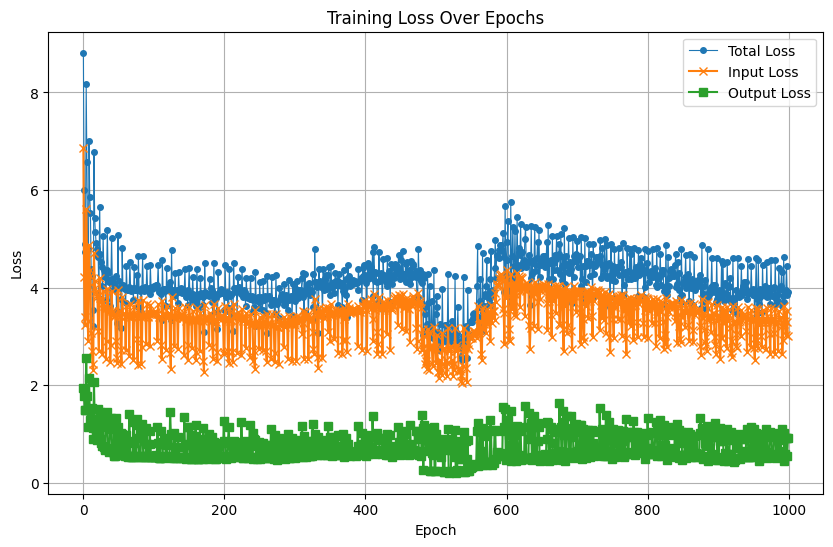

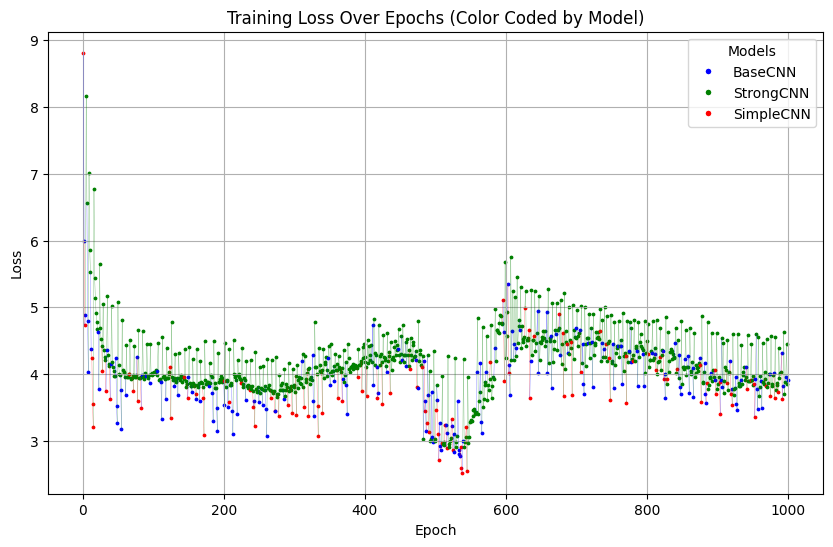

In [25]:
plt.figure(1,figsize=(10, 6))
plt.plot(epoch_losses, label='Total Loss', marker='o',linewidth=0.8,markersize=4 )
plt.plot(epoch_input_losses, label='Input Loss', marker='x')
plt.plot(epoch_output_losses, label='Output Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


model_colors = {
    "BaseCNN": "blue",
    "StrongCNN": "green",
    "SimpleCNN": "red"
}
plt.figure(2,figsize=(10, 6))

for i, loss in enumerate(epoch_losses):
    # Use plot to connect the points with lines
  
    if i > 0:
        plt.plot([i, i + 1], [epoch_losses[i - 1], loss], color=model_colors[epoch_models[i]],alpha=0.5,   # Adjust transparency
        linewidth=0.3 ) # Set thinner line width)

    # Scatter individual points
    plt.scatter(i + 1, loss, color=model_colors[epoch_models[i]],s=3, label=epoch_models[i] if i == 0 or epoch_models[i] != epoch_models[i-1] else '')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Color Coded by Model)')
plt.grid(True)

# Create a legend for the models
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=5, label=model) for model, color in model_colors.items()]
plt.legend(handles=handles, title="Models")

plt.show()

# VERIFICATION

In [13]:
# Save the ATN in the newer `.keras` format for future compatibility

# Define model naming function
def generate_model_name(base_name, beta, epochs, structure):
    # Format the model name with hyperparameters
    return f"{base_name}_beta-{beta}_epochs-{epochs}_{structure}.keras"

# Specify model details
#base_name = "adversarial_transformation_network"

#structure = "conv2d_transpose"  # Example structure (descriptive)

# Generate the model name
#model_name = generate_model_name(base_name, beta, epochs, structure)
model_name='ATN_model/ATNMultuCNN_Vote_ATN2.keras'
# Save the ATN with the generated name
atn.save(model_name)
print(f"ATN saved successfully as {model_name}")



ATN saved successfully as ATN_model/ATNMultuCNN_Vote_ATN2.keras


In [14]:
# Load Model


#loaded_atn_model = tf.keras.models.load_model('ATN_model/ATNPure.keras')

2025-01-16 08:59:08.273428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 0s 55ms/step
True Labels: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Original Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Transformed Predictions: [7 0 7 2 9 6 7 5 5 8 8 0 9 9 2 8 5 5 7 2 9 5 3 0 8 5 5 5 8 7 7 5]
1/1 [==============================] - 0s 54ms/step


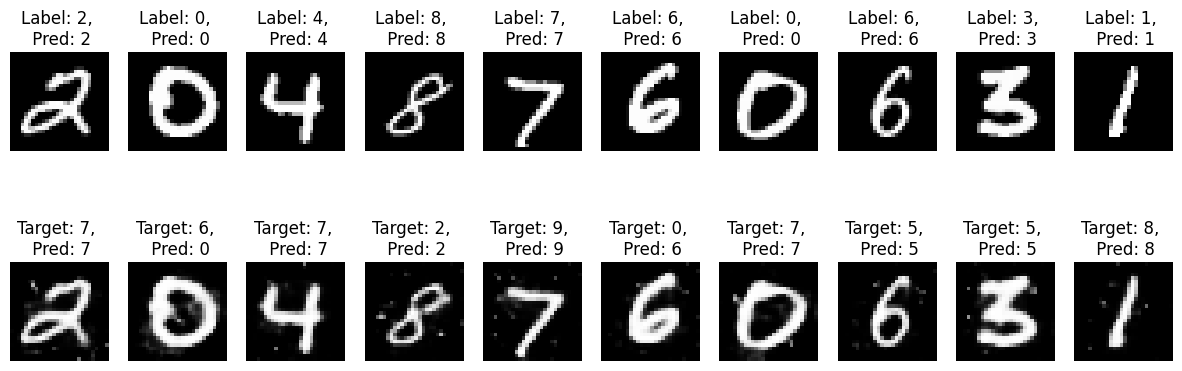

In [15]:

import matplotlib.pyplot as plt







# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch in dataset.take(1):  # Take one batch (two elements per batch in the dataset)
        # Generate transformed images
        x_transformed = atn.predict(x_batch)

        # Get predictions for the original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)

        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)

        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())

        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed, original_model.predict(x_batch))
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed, original_pred):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')

        # Transformed image
        second_highest_target = get_second_highest_target(original_pred[i: i + 1])[0]  # Compute target dynamically
        second_highest_class = tf.argmax(second_highest_target).numpy()

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Target: {second_highest_class}, \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')

    plt.show()


# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [16]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0

    for x_batch, y_original_batch in dataset:  # Only unpack two elements
        if atn:
            # Transform images using ATN
            x_batch = atn.predict(x_batch, verbose=0)  # Suppress verbose output
        # Get predictions from the model
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)
        y_true = tf.argmax(y_original_batch, axis=1)  # True labels
        # Count correct predictions
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]  # Batch size
    
    return correct / total  # Calculate accuracy


# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")


Accuracy on original images: 0.9870
Accuracy on transformed images: 0.2777
